In [32]:
# LIBRERIAS
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from scipy.signal import find_peaks
from datetime import datetime
from teorico import poisson, bose, expon
now = datetime.now()

# OPCIONAL
estilo_graficos = ["science", "nature"] #@param
plt.style.use(estilo_graficos)
texto_pt = 10 #@param
plt.rcParams['font.size'] = texto_pt
cm = 1/2.54  # factor de conversion a cm para que sea mas facil conocer la resolucion
proporciones = (8.5*cm, 6*cm) #@param
plt.rcParams['figure.figsize'] = proporciones
dpi = 200 #@param
plt.rcParams['figure.dpi'] = dpi

In [33]:
# FUNCIONES

def histogram(data, **kwargs):
    hist, bins = np.histogram(data, **kwargs)
    bin_cs = (bins[1:] + bins[:-1]) / 2
    bin_ws = (bins[1:] - bins[:-1])
    return hist, bin_cs, bin_ws[0]

def err_hist(hist, binw, N):
    p = binw * hist
    var = N * p * (1 - p)    # varianza**0.5 de una distribución binomial, la probabilidad de que el próximo evento caiga en algun bin está aproximada por la frecuencia de eventos que ya cayeron en el bin.
    err = var**0.5 / N # error normalizado (unidades de area en el histograma)
    return err / binw  # "altura" del error

def split_data(t, v, split_at):
    index = np.where(split_at == 1)[0]
    ts = np.split(t, indices_or_sections = index)
    vs = np.split(v, indices_or_sections = index)
    return ts, vs

def contar_fotocuentas(ts, vs, threshold, num_pantallas):
    counts = []
    for v in vs:
        peaks = find_peaks(-v, height = threshold)[0]
        counts.append(len(peaks))
    counts = np.array(counts)
    counts_n = 0
    for i in range(num_pantallas):
        counts_n += counts[i:i-num_pantallas]
    return counts_n

def sacar_tiempos_de_comunicacion(ts):
    t_last = 0
    ts_new = []
    for t in ts:
        t_gap = t[0] - t_last
        t = t - t_gap
        t_last = t[-1]
        ts_new.append(t)
    return np.array(ts_new)

def calcular_dts(ts, vs, threshold):
    t = np.hstack(sacar_tiempos_de_comunicacion(ts))
    v = np.hstack(vs)
    peaks = find_peaks(-v, height = threshold)[0]
    dts = np.diff(t[peaks])
    return dts

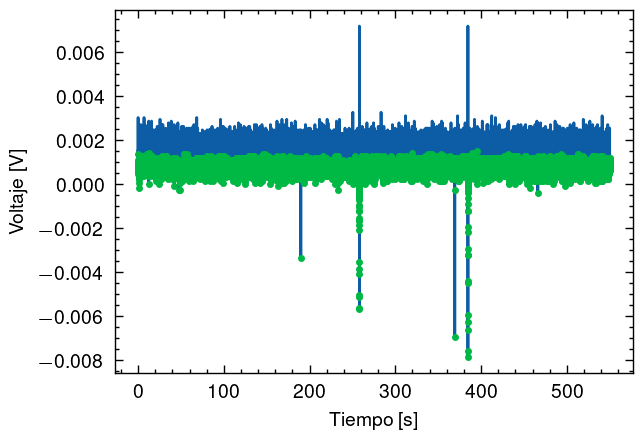

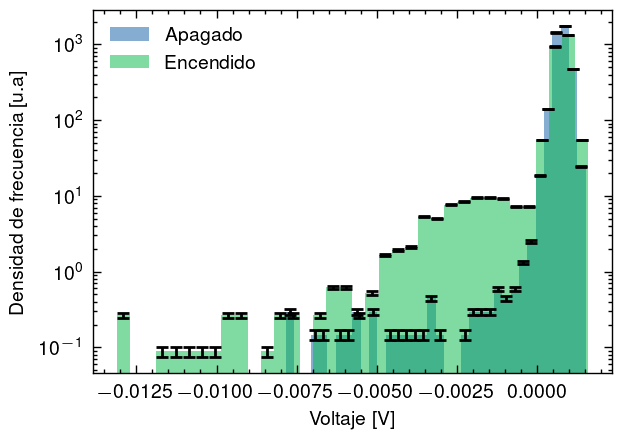

In [34]:
off_file_path = "datos/[2023-11-17_13-18-36] [barrido] DARIO NOS AYUDO laser apagado polarizador 65 500 ns 2 mVbw 51 ohms.txt"
t, v, s =  np.loadtxt(off_file_path, skiprows = 8, delimiter = ",", unpack = True)
peaks = find_peaks(-v, prominence = 0.001)[0]
plt.plot(t, v)
plt.plot(t[peaks], v[peaks], ".")
plt.ylabel("Voltaje [V]")
plt.xlabel("Tiempo [s]")
plt.show()

hist, bincs, binw = histogram(v[peaks], bins = 36, density = True)
plt.bar(bincs, hist, width = binw, yerr = err_hist(hist, binw, len(v)), alpha = 0.5, error_kw = dict(ecolor = "k", capsize=2), label = "Apagado")


on_file_path = "datos/[2023-11-17_13-07-51] [barrido] DARIO NOS AYUDO laser prendido polarizador 65 500 ns 2 mVbw 51 ohms.txt"
t, v, s =  np.loadtxt(on_file_path, skiprows = 8, delimiter = ",", unpack = True)
peaks = find_peaks(-v, prominence = 0.001)[0]
hist, bincs, binw = histogram(v[peaks], bins = 36, density = True)
plt.bar(bincs, hist, width = binw, yerr = err_hist(hist, binw, len(v)), alpha = 0.5, error_kw = dict(ecolor = "k", capsize=2), label = "Encendido")

plt.legend()
plt.semilogy()
plt.ylabel("Densidad de frecuencia [u.a]")
plt.xlabel("Voltaje [V]")
plt.show()

---
1
mu: 1.5230460921843687


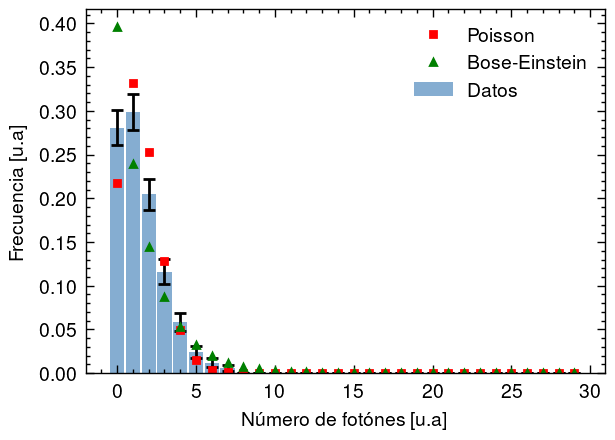

---
2
mu: 3.0502008032128516


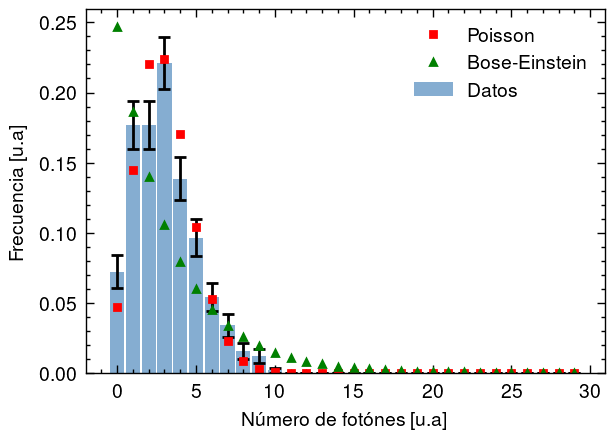

---
3
mu: 4.575452716297787


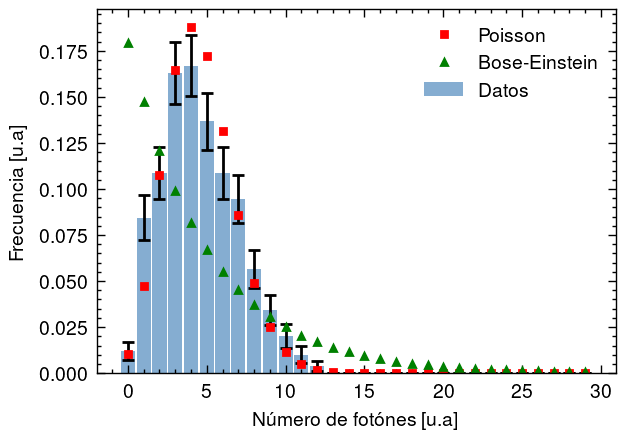

---
4
mu: 6.104838709677419


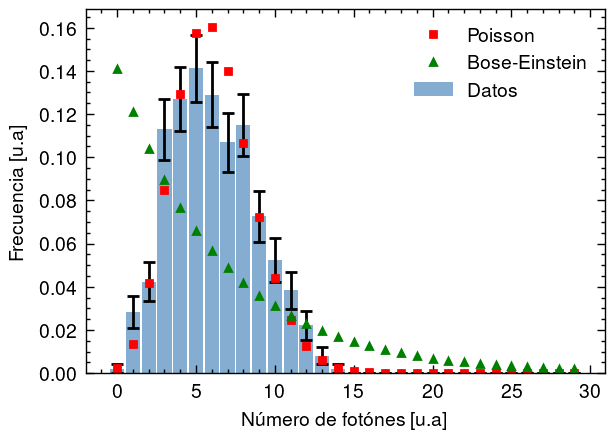

---
5
mu: 7.636363636363637


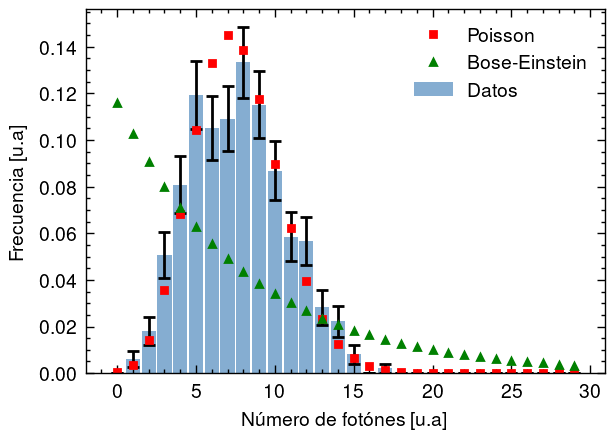

In [35]:
# COUNTS
threshold = 0.001
ts, vs = split_data(t, v, split_at = s)
for n in range(1, 6, 1):
    print("---\n" + str(n))
    counts = contar_fotocuentas(ts, vs, threshold, num_pantallas = n)
    mu = np.mean(counts)
    print("mu:", mu)

    bins = np.arange(-0.5, 30.5, 1)
    hist, bincs, binw = histogram(counts, bins = bins, density = True)
    
    plt.bar(bincs, hist, width = binw*0.9, yerr = err_hist(hist, binw, len(counts)), alpha = 0.5, error_kw = dict(ecolor = "k", capsize=2), label = "Datos")
    plt.plot(bincs, poisson(bincs, mu), "s", ms = 2, color = "r", label = "Poisson")
    plt.plot(bincs, bose(bincs, mu), "^", ms = 2, color = "g", label = "Bose-Einstein")

    plt.ylabel("Frecuencia [u.a]")
    plt.xlabel("Número de fotónes [u.a]")
    plt.legend()
    plt.show()

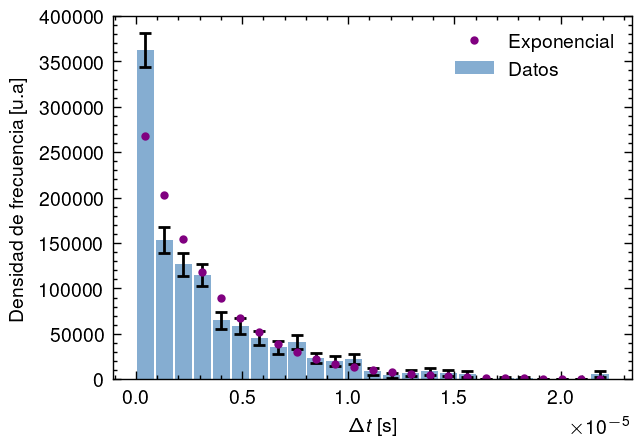

In [36]:
# DISTRIBUCIÓN TEMPORAL
dts = calcular_dts(ts, vs, threshold)
mu = np.mean(dts)
hist, bincs, binw = histogram(dts, bins = "auto", density = True)

plt.bar(bincs, hist, width = binw*0.9, yerr = err_hist(hist, binw, len(dts)), alpha = 0.5, error_kw = dict(ecolor = "k", capsize=2), label = "Datos")
plt.plot(bincs, expon(bincs, mu), "o", ms = 2, color = "purple", label = "Exponencial")

plt.ylabel("Densidad de frecuencia [u.a]")
plt.xlabel("$\Delta t$ [s]")
plt.legend()
plt.show()